<a href="https://colab.research.google.com/github/RafaellaDoki/TCC/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Detecção de patologias cancerigenas em tomografias pulmonares usando redes neurais</center>

## Configuração do ambiente

Para a execução desse código é necessário ter baixado o jupyter notebook e o Anaconda3, segue os links abaixo:

Jupyter: https://jupyter.org/install

Anaconda: https://www.anaconda.com/products/individual#Downloads

Depois de instalado o anaconda, devemos criar um ambiente rodando os seguintes comandos no Anaconda Console:

```bash
conda create --name TensorFlowEnv python=3.7
conda activate TensorFlowEnv
conda install tensorflow-gpu=2.1 tensorflow=2.1
conda install matplotlib numpy scikit-learn
conda install -c conda-forge
conda install -c anaconda ipykernel
conda install -c conda-forge opencv
```

Em um console com acesso a python, podendo ser uma nova instancia do anaconda, deve-se configurar um kernel para jupyter apontando para o perfil criado no ambiente anaconda. Assim será listado no jupyter o ambiente com as bibliotecas instaladas anteriormente.

```bash
python -m ipykernel install --user --name=TensorFlowEnv
```

## Importando bibliotecas

Para a imlementação do aloritmo é necessário carregar as bibliotecas para manipução das imagens leitura de arquivo XML, manipulação de matrizes e computação numérica, framework de aprendizagem de maquina, API de aprendizado profundo, mecanismo de avaliação dos resultados e bibliotecas de apoio a diagnóstico.

In [1]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.utils import shuffle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import glob
import random
from scipy.interpolate import interp1d
import cv2
from sklearn.metrics import confusion_matrix
import itertools

## Checando e configurando Tensorflow GPU

Checando o suporte a uso de GPU no treinamento e ativando a configuração de ajuste de crescimento de memoria da GPU que faz com que a alocação possa ser expandida conforme a necessidade da aplicação for aumentando.

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
print('Uso de GPU suportado:', len(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Uso de GPU suportado: 1


## Lendo uma imagem .MAT

Exemplo de carga de um arquivo de imagem .MAT, leitura dos atributos e visualição da imagem.

In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


Varificando se o acesso ao drive fico de forma correta

In [ ]:
print(glob.glob("/content/drive/MyDrive/*"))


['/content/drive/MyDrive/ieee754.ps', '/content/drive/MyDrive/contatos.vcf', '/content/drive/MyDrive/CM0VB9QW8AIJMwJ.jpg', '/content/drive/MyDrive/465928_246862048736538_530278344_o.jpg', '/content/drive/MyDrive/Alemanha', '/content/drive/MyDrive/Boletos', '/content/drive/MyDrive/Currículos', '/content/drive/MyDrive/Marvel.gsheet', '/content/drive/MyDrive/t2', '/content/drive/MyDrive/Rafa Docs', '/content/drive/MyDrive/Fundamentos de economia-20201203T223315Z-001.zip', '/content/drive/MyDrive/Engenharia da Computação - PUCRS', '/content/drive/MyDrive/Trabalho', '/content/drive/MyDrive/Series.gdoc', '/content/drive/MyDrive/$$', '/content/drive/MyDrive/Planilha sem título.gsheet', '/content/drive/MyDrive/Colab Notebooks']


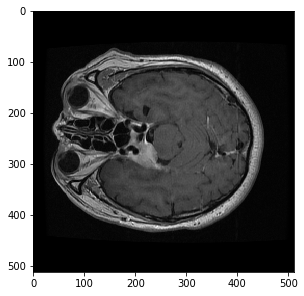

In [4]:
mat = h5py.File('/content/drive/MyDrive/Colab Notebooks/dataset/8.mat', 'r')
tumorBorder = mat['cjdata']['tumorBorder']
image = mat['cjdata']['image']
npTumorBorder = np.array(tumorBorder[:])
tumor = np.zeros((int(npTumorBorder.size/2),2))
tumorBB = np.zeros((2,2))
tumorBB[0] = (513,513)
tumorBB[1] = (-1,-1)

plt.rcParams["figure.figsize"] = (6.4, 4.8)
for i in range(int(npTumorBorder.size/2)):
    tumor[i] = (npTumorBorder[0][1::2][i],npTumorBorder[0][0::2][i])
    if(tumorBB[0][0] >= npTumorBorder[0][1::2][i]):
        tumorBB[0][0] = npTumorBorder[0][1::2][i]
    if(tumorBB[0][1] >= npTumorBorder[0][0::2][i]):
        tumorBB[0][1] = npTumorBorder[0][0::2][i]
    if(tumorBB[1][0] <= npTumorBorder[0][1::2][i]):
        tumorBB[1][0] = npTumorBorder[0][1::2][i]
    if(tumorBB[1][1] <= npTumorBorder[0][0::2][i]):
        tumorBB[1][1] = npTumorBorder[0][0::2][i]
plt.imshow(image, interpolation='nearest', cmap='gray')
plt.show()

## Lendo a informação de anotação

As informções estão codificadas no arquivo .MAT, na propriedade label.

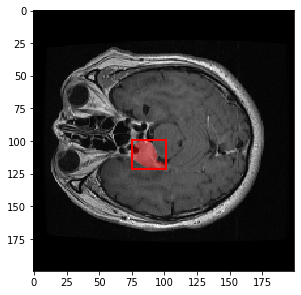

In [5]:
tensor_image = np.array(image)
plt.rcParams["figure.figsize"] = (6.4, 4.8)
tumor_tensor = cv2.resize(tensor_image, dsize=(200,200), interpolation=cv2.INTER_CUBIC)
ax = plt.imshow(tumor_tensor, interpolation='nearest', cmap='gray')
plt.rcParams["figure.figsize"] = (6.4, 4.8)
rangeAdjust = interp1d([0,(512-1)], [0,200-1])
tumor_tensor = np.zeros(tumor.shape)
for i in range(tumor.shape[0]):
    tumor_tensor[i][0] = rangeAdjust(tumor[i][0])
    tumor_tensor[i][1] = rangeAdjust(tumor[i][1])

p = patches.Polygon(tumor_tensor, facecolor = 'red', alpha=0.4)
plt.gca().add_artist(p)
plt.gca().add_patch(patches.Rectangle((rangeAdjust(tumorBB[0][0]),rangeAdjust(tumorBB[0][1])),rangeAdjust(tumorBB[1][0])-rangeAdjust(tumorBB[0][0]),rangeAdjust(tumorBB[1][1])-rangeAdjust(tumorBB[0][1]),linewidth=2,edgecolor='r',facecolor='none'))
plt.show()

## Carregando imagens e anotações em lote

Nesssa etapa serão carregadas as imagens (MRI) e as anotações em matrizes que serão usadas pelo tensorFlow no processo de aprendizagem, teste e avaliação.

### Definição de constantes e inicializações

Para configurar a execução da carga em lote foram definirdos algumas constantes e inicizlizado algumas matrizes.

In [6]:
TRAIN_SAMPLES_SIZE = 100 #2964
TRAIN_SAMPLES_NO_TUMOR_SIZE = 100 #295
TEST_SAMPLES_SIZE = 100 #100
VALIDATION_SAMPLES_SIZE = 100 #100
IMAGE_SIZE = 200

train_labels_features =  []
train_labels_coordinates =  []
train_samples = []
test_labels_features =  []
test_labels_coordinates =  []
test_samples = []
validation_labels_features =  []
validation_labels_coordinates =  []
validation_samples = []

load_mat_filename = []

load_train_labels_features =  []
load_train_labels_coordinates =  []
load_train_samples = []
load_test_labels_features =  []
load_test_labels_coordinates =  []
load_test_samples = []
load_validation_labels_features =  []
load_validation_labels_coordinates =  []
load_validation_samples = []

### Leitura de anotações

Para facilitar o carregamento em lote dos dados foi desenvolvida uma função que retorna as anotações já normalizadas.

In [7]:
def readFeatures(mat,skip=0):
    label = mat['label'][:][0][0]
    no_tumor = 0
    meningioma = 0
    glioma = 0
    pituitary = 0
    # 1 for meningioma, 2 for glioma, 3 for pituitary tumor, 0 for no tumor
    if(label == 1):
        meningioma = 1.0
    elif(label == 2):
        glioma = 1.0
    elif(label == 3):
        pituitary = 1.0
    elif(label == 0):
        no_tumor = 1.0
    return [no_tumor,meningioma,glioma,pituitary]
def readCoordinates(mat,skip=0):
    tumorBorder = mat['tumorBorder']
    npTumorBorder = np.array(tumorBorder[:])
    tumor = np.zeros((int(npTumorBorder.size/2),2))
    tumorBB = np.zeros((2,2))
    if(skip==0):
        tumorBB[0] = (513,513)
        tumorBB[1] = (-1,-1)

    for i in range(int(npTumorBorder.size/2)):
        tumor[i] = (npTumorBorder[0][1::2][i],npTumorBorder[0][0::2][i])
        if(tumorBB[0][0] >= npTumorBorder[0][1::2][i]):
            tumorBB[0][0] = npTumorBorder[0][1::2][i]
        if(tumorBB[0][1] >= npTumorBorder[0][0::2][i]):
            tumorBB[0][1] = npTumorBorder[0][0::2][i]
        if(tumorBB[1][0] <= npTumorBorder[0][1::2][i]):
            tumorBB[1][0] = npTumorBorder[0][1::2][i]
        if(tumorBB[1][1] <= npTumorBorder[0][0::2][i]):
            tumorBB[1][1] = npTumorBorder[0][0::2][i]
    rangeAdjust = interp1d([0,(512-1)], [0,1])
    xmin = 0.0; ymin = 0.0; xmax = 0.0; ymax = 0.0;
    if(skip == 0):
        xmin = float(rangeAdjust(tumorBB[0][0]))
        ymin = float(rangeAdjust(tumorBB[0][1]))
        xmax = float(rangeAdjust(tumorBB[1][0]))
        ymax = float(rangeAdjust(tumorBB[1][1]))
    
    return [xmin,ymin,xmax,ymax]

### Definição de função de conversão de image

Implementamos uma função para converte o array de imagens para o formato esperado pelo TensorFlow.

In [8]:
def convImageToTensor(image_array):
    tensor_image = np.array(image_array)
    if tensor_image.shape == (512, 512, 3):
        tensor_image = tensor_image.transpose(2, 0, 1)[0]
        tensor_image = cv2.resize(tensor_image, dsize=(200,200), interpolation=cv2.INTER_CUBIC)
    else:
        tensor_image = cv2.resize(tensor_image, dsize=(200,200), interpolation=cv2.INTER_CUBIC)
    tensor_image = tensor_image.reshape(tensor_image.shape + (1,))
    tensor_image=(tensor_image - np.min(tensor_image))/np.ptp(tensor_image)
    return tensor_image.tolist()

### Carga em lote dos dados

Para carregar os dados foram sorteados algumas amostras das pastas que contém as images medicas (MRI) e carregar suas anotações quando apropriado. As listas finais estaram em ordem, sendo todos os dados positivos no inicio e todos os dados negativos no final.

In [9]:
positive_batch = int(TRAIN_SAMPLES_SIZE + (TEST_SAMPLES_SIZE + VALIDATION_SAMPLES_SIZE) / 2)
negative_batch = int(TRAIN_SAMPLES_NO_TUMOR_SIZE + (TEST_SAMPLES_SIZE + VALIDATION_SAMPLES_SIZE) / 2)
for has_cancer_dcm_file_path in random.sample(glob.glob('/content/drive/My Drive/Colab Notebooks/dataset'+os.sep+'*.mat'), positive_batch):
    total = round(((len(load_train_samples) + len(load_test_samples) + len(load_validation_samples))*100)/(TRAIN_SAMPLES_SIZE + TRAIN_SAMPLES_NO_TUMOR_SIZE + TEST_SAMPLES_SIZE + VALIDATION_SAMPLES_SIZE),2)
    print(has_cancer_dcm_file_path, total , '%')
    load_mat_filename.append(has_cancer_dcm_file_path)
    mat = h5py.File(has_cancer_dcm_file_path, 'r')
    image = mat['cjdata']['image']
    
    if len(load_train_samples) < (TRAIN_SAMPLES_SIZE):
        load_train_samples.append(convImageToTensor(image))
        load_train_labels_features.append(readFeatures(mat['cjdata']))
        load_train_labels_coordinates.append(readCoordinates(mat['cjdata']))
    elif len(load_train_samples) + len(load_test_samples) < (TRAIN_SAMPLES_SIZE + TEST_SAMPLES_SIZE/2):
        load_test_samples.append(convImageToTensor(image))
        load_test_labels_features.append(readFeatures(mat['cjdata']))
        load_test_labels_coordinates.append(readCoordinates(mat['cjdata']))
    else:
        load_validation_samples.append(convImageToTensor(image))
        load_validation_labels_features.append(readFeatures(mat['cjdata']))
        load_validation_labels_coordinates.append(readCoordinates(mat['cjdata']))
        
for dont_has_cancer_dcm_file_path in random.sample(glob.glob('/content/drive/My Drive/Colab Notebooks/no_mat'+os.sep+'*.mat'), negative_batch):
    total = round(((len(load_train_samples) + len(load_test_samples) + len(load_validation_samples))*100)/(TRAIN_SAMPLES_SIZE + TRAIN_SAMPLES_NO_TUMOR_SIZE + TEST_SAMPLES_SIZE + VALIDATION_SAMPLES_SIZE),2)
    print(dont_has_cancer_dcm_file_path, total , '%')
    load_mat_filename.append(dont_has_cancer_dcm_file_path)
    mat = h5py.File(dont_has_cancer_dcm_file_path, 'r')
    image = mat['cjdata']['image']
    
    if len(load_train_samples) < (TRAIN_SAMPLES_SIZE + TRAIN_SAMPLES_NO_TUMOR_SIZE):
        load_train_samples.append(convImageToTensor(image))
        load_train_labels_features.append(readFeatures(mat['cjdata'],1))
        load_train_labels_coordinates.append(readCoordinates(mat['cjdata'],1))
    elif len(load_train_samples) + len(load_test_samples) < (TRAIN_SAMPLES_SIZE + TRAIN_SAMPLES_NO_TUMOR_SIZE + TEST_SAMPLES_SIZE):
        load_test_samples.append(convImageToTensor(image))
        load_test_labels_features.append(readFeatures(mat['cjdata'],1))
        load_test_labels_coordinates.append(readCoordinates(mat['cjdata'],1))
    else:
        load_validation_samples.append(convImageToTensor(image))
        load_validation_labels_features.append(readFeatures(mat['cjdata'],1))
        load_validation_labels_coordinates.append(readCoordinates(mat['cjdata'],1))
total = round(((len(load_train_samples) + len(load_test_samples) + len(load_validation_samples))*100)/(TRAIN_SAMPLES_SIZE + TRAIN_SAMPLES_NO_TUMOR_SIZE + TEST_SAMPLES_SIZE + VALIDATION_SAMPLES_SIZE),2)
print('Done', total , '%')

/content/drive/My Drive/Colab Notebooks/dataset/82.mat 0.0 %
/content/drive/My Drive/Colab Notebooks/dataset/776.mat 0.25 %
/content/drive/My Drive/Colab Notebooks/dataset/676.mat 0.5 %
/content/drive/My Drive/Colab Notebooks/dataset/887.mat 0.75 %
/content/drive/My Drive/Colab Notebooks/dataset/3048.mat 1.0 %
/content/drive/My Drive/Colab Notebooks/dataset/54.mat 1.25 %
/content/drive/My Drive/Colab Notebooks/dataset/2449.mat 1.5 %
/content/drive/My Drive/Colab Notebooks/dataset/2817.mat 1.75 %
/content/drive/My Drive/Colab Notebooks/dataset/225.mat 2.0 %
/content/drive/My Drive/Colab Notebooks/dataset/2802.mat 2.25 %
/content/drive/My Drive/Colab Notebooks/dataset/1354.mat 2.5 %
/content/drive/My Drive/Colab Notebooks/dataset/470.mat 2.75 %
/content/drive/My Drive/Colab Notebooks/dataset/973.mat 3.0 %
/content/drive/My Drive/Colab Notebooks/dataset/503.mat 3.25 %
/content/drive/My Drive/Colab Notebooks/dataset/1432.mat 3.5 %
/content/drive/My Drive/Colab Notebooks/dataset/2375.mat 3.

## Embaralhando registros

Os dados foram carregados de forma que os primeiros registros são todos positvos (tem cancer) e os ultimos são todos negativos (não tem cancer) para deixar a distribuição homogenia os dados foram embaralhados. Nessa parte também as matrizes criadas para matrizes do tipo numpy que são suportadas pelo TensorFlow.

Obs: os prints servem apenas como validação, verificando se as imagens foram corrompidas no carregamento ou não.

In [ ]:
print(len(load_train_samples))
for i in range(len(load_train_samples)):
    if(len(load_train_samples[i]) != 200):
        print(i, load_mat_filename[i])
        print(len(load_train_samples[i]))

200


In [ ]:
print(len(load_test_samples))
for i in range(len(load_test_samples)):
    if(len(load_test_samples[i]) != 200):
        print(i, load_mat_filename[len(load_train_samples)+i])
        print(len(load_test_samples[i]))

100


In [ ]:
print(len(load_validation_samples))
for i in range(len(load_validation_samples)):
    if(len(load_validation_samples[i]) != 200):
        print(i, load_mat_filename[len(load_train_samples)+len(load_test_samples)+i])
        print(len(load_validation_samples[i]))

100


In [10]:
train_labels_features = np.array(load_train_labels_features)
train_labels_coordinates = np.array(load_train_labels_coordinates)
train_samples = np.array(load_train_samples)

test_labels_features = np.array(load_test_labels_features)
test_labels_coordinates = np.array(load_test_labels_coordinates)
test_samples = np.array(load_test_samples)

validation_labels_features = np.array(load_validation_labels_features)
validation_labels_coordinates = np.array(load_validation_labels_coordinates)
validation_samples = np.array(load_validation_samples)

train_labels_features, train_labels_coordinates, train_samples = shuffle(train_labels_features, train_labels_coordinates, train_samples)
test_labels_features, test_labels_coordinates, test_samples = shuffle(test_labels_features, test_labels_coordinates, test_samples)
validation_labels_features, validation_labels_coordinates, validation_samples = shuffle(validation_labels_features, validation_labels_coordinates, validation_samples)


Verificando se os tamanhos estão corretos

In [ ]:
assert len(train_labels_features) == TRAIN_SAMPLES_SIZE + TRAIN_SAMPLES_NO_TUMOR_SIZE
assert len(train_labels_coordinates) == TRAIN_SAMPLES_SIZE + TRAIN_SAMPLES_NO_TUMOR_SIZE
assert len(train_samples) == TRAIN_SAMPLES_SIZE + TRAIN_SAMPLES_NO_TUMOR_SIZE

assert len(test_labels_features) == TEST_SAMPLES_SIZE
assert len(test_labels_coordinates) == TEST_SAMPLES_SIZE
assert len(test_samples) == TEST_SAMPLES_SIZE

assert len(validation_labels_features) == VALIDATION_SAMPLES_SIZE
assert len(validation_labels_coordinates) == VALIDATION_SAMPLES_SIZE
assert len(validation_samples) == VALIDATION_SAMPLES_SIZE

Inspecionando os dados carregados

In [ ]:
print(test_labels_features.shape)
print(test_labels_features[0].shape)

(100, 4)
(4,)


In [ ]:
print(test_labels_features[:])
print(test_labels_coordinates[:])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0.

## Definição do modelo

Para a criação do modelo da rede neural convolucional (CNN) a API Keras foi usada para a definição dos tipos de camadas.

In [11]:
input_format = Input((IMAGE_SIZE,IMAGE_SIZE,1)) #matriz num 200x200, 1 (intensidade de alguma coisa)
layer_1_conv2d = Conv2D(16, (3,3), activation='relu')(input_format)
layer_2_mp2d = MaxPooling2D(2,2)(layer_1_conv2d)
layer_3_conv2d = Conv2D(32, (3,3), activation='relu')(layer_2_mp2d)
layer_4_mp2d = MaxPooling2D(2,2)(layer_3_conv2d)
layer_5_conv2d = Conv2D(64, (3,3), activation='relu')(layer_4_mp2d)

# features bifurcation
layer_6_1_mp2d = MaxPooling2D(pool_size = (4))(layer_5_conv2d)
layer_7_1_ftn = Flatten()(layer_6_1_mp2d) # pega uma matriz de multidimenciona e faço ele virar um array. Normalizando
layer_8_1_dns = Dense(16, activation='tanh')(layer_7_1_ftn) #pega uma quantida absurda de saída e diminui ela
layer_9_1_bnm = BatchNormalization()(layer_8_1_dns) #pega as coisas q tão em numero gigantesco e deixa entre -1 e 1
features_out = Dense(4, activation='sigmoid', name='features_out')(layer_9_1_bnm) #diminui ainda, tirando novas médias

# coodinates bifurcation
layer_6_2_mp2d = MaxPooling2D(2,2)(layer_5_conv2d)
layer_7_2_flt = Flatten()(layer_6_2_mp2d) #quantidade de coisas em uma dimensão, pa
layer_8_2_dns = Dense(128, activation='relu')(layer_7_2_flt)
layer_9_2_dns = Dense(64, activation='relu')(layer_8_2_dns)
layer_10_2_dns = Dense(32, activation='relu')(layer_9_2_dns)
coordinates_out = Dense(4, activation="sigmoid", name='coordinates_out')(layer_10_2_dns)

model = Model(inputs=input_format, outputs=[features_out,coordinates_out])

Geração do diagrama de blocos que representa a estrutura geral da CNN.

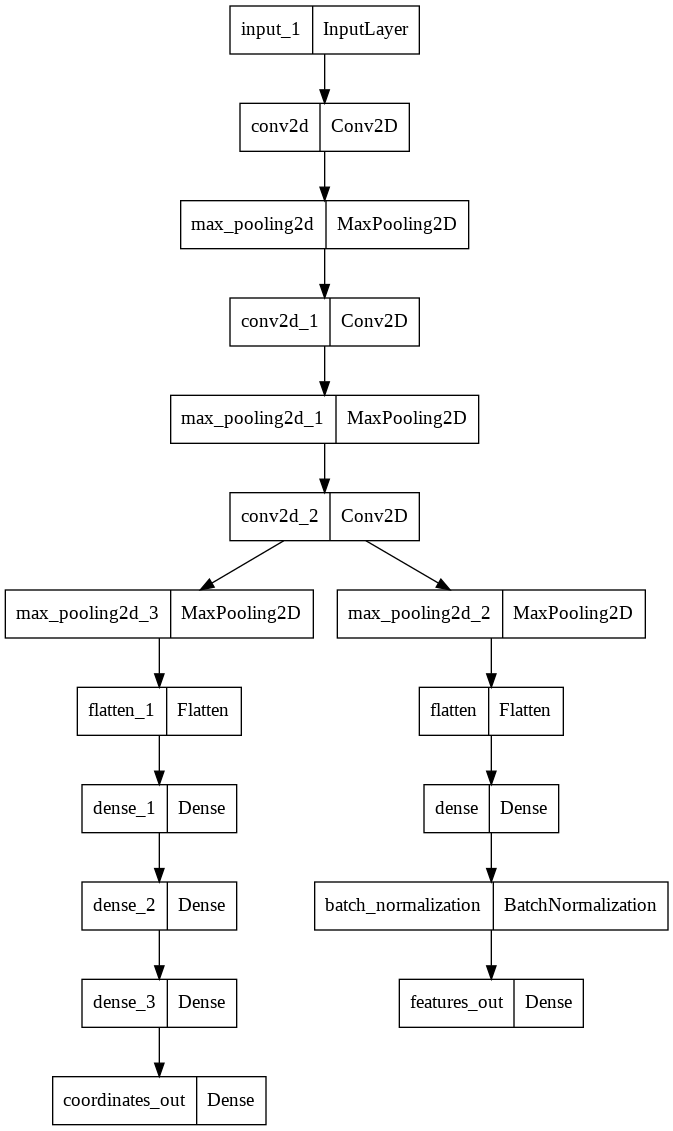

In [ ]:
keras.utils.plot_model(model, "cnn_model.png")

### Sumario da configuração da rede

Para verificar a rede configurada, a função sumário foi chamada.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 198, 198, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 99, 99, 16)   0           ['conv2d[0][0]']                 
                                                                                              

### Construção do modelo

A configuração deve ser construida antes de dar inicio ao treinamento.

In [12]:
model.compile(optimizer='adam', loss=['binary_crossentropy','mean_squared_error'], metrics=['accuracy'])

### Treino da rede

Executando o treinamento da rede com as imagens de entrada e suas anotações.

In [ ]:
train = model.fit(train_samples,[train_labels_features,train_labels_coordinates], validation_data=(validation_samples,[validation_labels_features,validation_labels_coordinates]), batch_size=32, epochs=30, verbose=2) #epochs=3000

Epoch 1/30
7/7 - 15s - loss: 0.7106 - features_out_loss: 0.6362 - coordinates_out_loss: 0.0744 - features_out_accuracy: 0.5400 - coordinates_out_accuracy: 0.2550 - val_loss: 0.7173 - val_features_out_loss: 0.6571 - val_coordinates_out_loss: 0.0601 - val_features_out_accuracy: 0.5000 - val_coordinates_out_accuracy: 0.3000 - 15s/epoch - 2s/step
Epoch 2/30
7/7 - 0s - loss: 0.5712 - features_out_loss: 0.5204 - coordinates_out_loss: 0.0508 - features_out_accuracy: 0.7600 - coordinates_out_accuracy: 0.3300 - val_loss: 0.6725 - val_features_out_loss: 0.6260 - val_coordinates_out_loss: 0.0465 - val_features_out_accuracy: 0.5300 - val_coordinates_out_accuracy: 0.2100 - 199ms/epoch - 28ms/step
Epoch 3/30
7/7 - 0s - loss: 0.5178 - features_out_loss: 0.4754 - coordinates_out_loss: 0.0424 - features_out_accuracy: 0.8150 - coordinates_out_accuracy: 0.3150 - val_loss: 0.6541 - val_features_out_loss: 0.6156 - val_coordinates_out_loss: 0.0385 - val_features_out_accuracy: 0.5600 - val_coordinates_out_ac

### Avaliação dos resultados

Rodando um teste para avaliar os resultados.

In [ ]:
print("Resultados nas images de teste")
results = model.evaluate(test_samples, [test_labels_features,test_labels_coordinates])
print("test loss, test acc:", results)

Resultados nas images de teste
4/4 [==============================] - 0s 10ms/step - loss: 0.3206 - features_out_loss: 0.3096 - coordinates_out_loss: 0.0110 - features_out_accuracy: 0.8700 - coordinates_out_accuracy: 0.7000
test loss, test acc: [0.32056453824043274, 0.30958470702171326, 0.010979874059557915, 0.8700000047683716, 0.699999988079071]


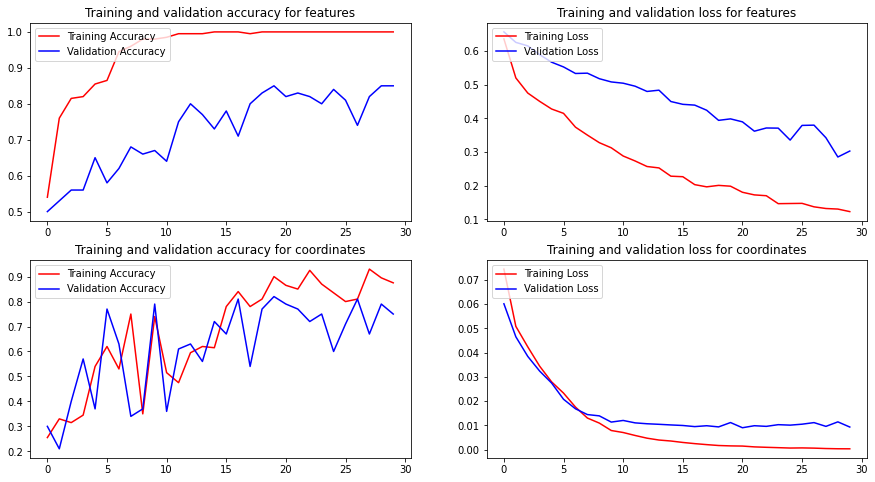

In [ ]:
acc_f=train.history['features_out_accuracy']
val_acc_f=train.history['val_features_out_accuracy']
loss_f=train.history['features_out_loss']
val_loss_f=train.history['val_features_out_loss']

acc_c=train.history['coordinates_out_accuracy']
val_acc_c=train.history['val_coordinates_out_accuracy']
loss_c=train.history['coordinates_out_loss']
val_loss_c=train.history['val_coordinates_out_loss']

epochs=range(len(acc_f)) # Get number of epochs

plt.rcParams["figure.figsize"] = (15,8)
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2)

ax0.plot(epochs, acc_f, 'r', label="Training Accuracy")
ax0.plot(epochs, val_acc_f, 'b', label="Validation Accuracy")
ax0.legend(loc="upper left")
ax0.set_title('Training and validation accuracy for features')

ax1.plot(epochs, loss_f, 'r', label="Training Loss")
ax1.plot(epochs, val_loss_f, 'b', label="Validation Loss")
ax1.legend(loc="upper left")
ax1.set_title('Training and validation loss for features')

ax2.plot(epochs, acc_c, 'r', label="Training Accuracy")
ax2.plot(epochs, val_acc_c, 'b', label="Validation Accuracy")
ax2.legend(loc="upper left")
ax2.set_title('Training and validation accuracy for coordinates')

ax3.plot(epochs, loss_c, 'r', label="Training Loss")
ax3.plot(epochs, val_loss_c, 'b', label="Validation Loss")
ax3.legend(loc="upper left")
ax3.set_title('Training and validation loss for coordinates')

plt.show()

[no_tumor,meningioma,glioma,pituitary] [no_tumor,meningioma,glioma,pituitary]
[1.33133495e-08 2.01140920e-05 9.99992013e-01 5.54935787e-06] [0. 0. 1. 0.]
[1.0000000e+00 3.2462210e-06 3.1623780e-17 2.0299704e-07] [1. 0. 0. 0.]
[5.2191018e-10 9.9998498e-01 9.9744721e-06 3.3793673e-05] [0. 1. 0. 0.]
[1.0000000e+00 9.9475300e-13 4.0054271e-10 7.2545615e-11] [1. 0. 0. 0.]
[1.0000000e+00 3.1972460e-09 3.1569585e-14 9.3266091e-05] [1. 0. 0. 0.]
[1.0000000e+00 9.9475300e-13 4.0054271e-10 7.2545615e-11] [1. 0. 0. 0.]
[1.33133495e-08 2.01140920e-05 9.99992013e-01 5.54935787e-06] [0. 0. 1. 0.]
[1.33133495e-08 2.01140920e-05 9.99992013e-01 5.54935787e-06] [0. 0. 1. 0.]


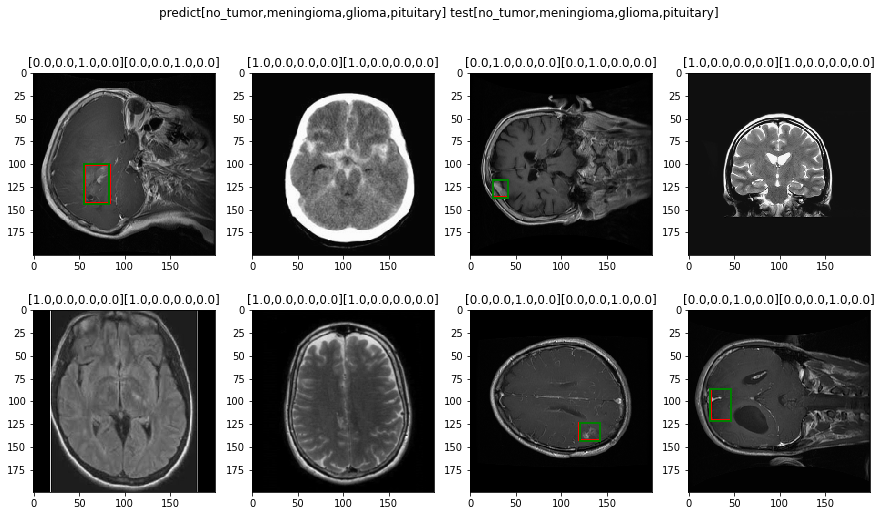

In [16]:
predictions_features,predictions_coordinates = model.predict(x=test_samples, verbose=0)
rangeAdjustTest = interp1d([0,1],[0,(200-1)])
rangeAdjustPredict = interp1d([0,1],[0,(200-1)])
iterator_skip = 40 # 0 8 16 24 32 40 48 56 64 
plt.rcParams["figure.figsize"] = (15,8)

ax = []
fig, ((ax0,ax1,ax2,ax3),(ax4,ax5,ax6,ax7)) = plt.subplots(2,4)
ax.append(ax0); ax.append(ax1); ax.append(ax2); ax.append(ax3)
ax.append(ax4); ax.append(ax5); ax.append(ax6); ax.append(ax7)
fig.suptitle('predict[no_tumor,meningioma,glioma,pituitary] test[no_tumor,meningioma,glioma,pituitary]')
print("[no_tumor,meningioma,glioma,pituitary] [no_tumor,meningioma,glioma,pituitary]")
for iterator in range(8):
    print(predictions_features[iterator+iterator_skip],test_labels_features[iterator+iterator_skip])
    prediction = predictions_coordinates[iterator+iterator_skip]
    xmin = rangeAdjustPredict(prediction[0])
    ymin = rangeAdjustPredict(prediction[1])
    xmax = rangeAdjustPredict(prediction[2])
    ymax = rangeAdjustPredict(prediction[3])
    ax[iterator].set_title("["+','.join(str(round(v,2)) for v in predictions_features[iterator+iterator_skip])+"]["+','.join(str(round(v,2)) for v in test_labels_features[iterator+iterator_skip])+"]");
    xmin_real = float(rangeAdjustTest(test_labels_coordinates[iterator+iterator_skip][0]))
    ymin_real = float(rangeAdjustTest(test_labels_coordinates[iterator+iterator_skip][1]))
    xmax_real = float(rangeAdjustTest(test_labels_coordinates[iterator+iterator_skip][2]))
    ymax_real = float(rangeAdjustTest(test_labels_coordinates[iterator+iterator_skip][3]))
    test_img = test_samples[iterator+iterator_skip].transpose(2, 0, 1)[0]
    ax[iterator].imshow(test_img, interpolation='nearest', cmap='gray')
    predition_region = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
    real_region = patches.Rectangle((xmin_real, ymin_real), xmax_real-xmin_real, ymax_real-ymin_real, linewidth=2, edgecolor='g', facecolor='none')
    
    ax[iterator].add_patch(predition_region)
    ax[iterator].add_patch(real_region)
    
plt.show()

Text(0.5, 10.530253492810175, 'Predicted label')

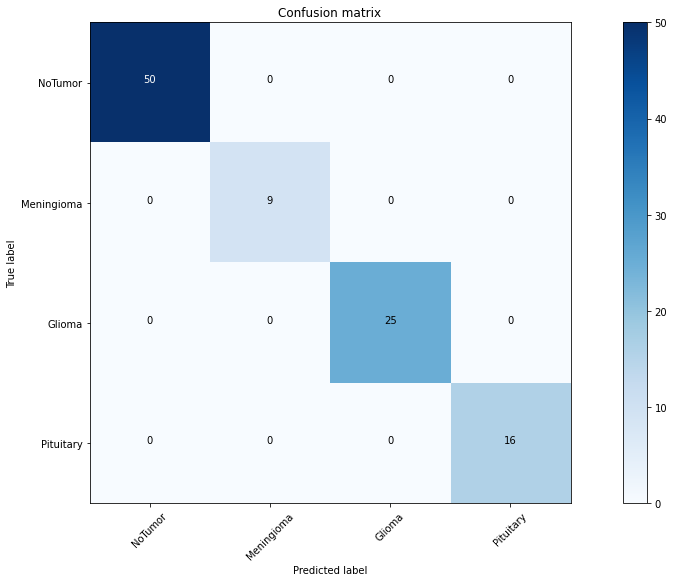

In [17]:
predictions_features_decoded = np.argmax(predictions_features, axis=-1)
test_labels_features_decoded = np.argmax(test_labels_features, axis=-1)

class_labels = ['NoTumor', 'Meningioma', 'Glioma', 'Pituitary']

cm = confusion_matrix(y_true=test_labels_features_decoded, y_pred=predictions_features_decoded)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = cm.max() / 2

for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Definir nome do arquivo pre-treinado

In [13]:
arquivo_treino = 'trainCNNFinal.h5'

Salvar arquivo de treino

In [ ]:
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/'+arquivo_treino) is False:
    print('Salvando arquivo de treino...')
    model.save('/content/drive/MyDrive/Colab Notebooks/'+arquivo_treino)
else:
    print('Ignorando o salvamento. Para salvar exclua o arquivo existente ou use outro nome.')

Salvando arquivo de treino...


Carregar arquivo de treino

In [14]:
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/'+arquivo_treino) is True:
    print('Carregando arquivo de treino...')
    model = load_model('/content/drive/MyDrive/Colab Notebooks/'+arquivo_treino)

Carregando arquivo de treino...


In [ ]:
import gc
gc.collect()

27341